# Tariff recommendation

We have at our disposal data on the behavior of customers who have already switched to these tariffs (from the draft course "Statistical Data Analysis"). You need to build a model for the classification problem that will select the appropriate rate. Data preprocessing is not required - you have already done it.

Build the model with the largest possible *accuracy* value. To pass the project successfully, we need to bring the percentage of correct answers to at least 0.75. Check *accuracy* on the test set yourself.

## Open and examine the file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

**Data Description**

Each object in the data set is information about the behavior of one user per month.

We known:
* `calls` - number of calls,
* `minutes` - total duration of calls in minutes,
* `messages` - number of sms messages,
* `mb_used` - used Internet traffic in Mb,
* `is_ultra` - what tariff did you use during the month ("Ultra" - **1**, "Smart" - **0**).

This time we don't have many fields, so it won't take long to see the data.

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.head(3)

calls  minutes  messages   mb_used  is_ultra
0   40.0   311.90      83.0  19915.42         0
1   85.0   516.75      56.0  22696.96         0
2   77.0   467.66      86.0  21060.45         0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


* no passes
* data types are also logical, in our dataset there are **5 fields**, all of them are numeric:
     * **4 fields** - real
     * **1 field** - integer

In [5]:
df.describe().T

count          mean          std  min         25%        50%  \
calls     3214.0     63.038892    33.236368  0.0     40.0000     62.000   
minutes   3214.0    438.208787   234.569872  0.0    274.5750    430.600   
messages  3214.0     38.281269    36.148326  0.0      9.0000     30.000   
mb_used   3214.0  17207.673836  7570.968246  0.0  12491.9025  16943.235   
is_ultra  3214.0      0.306472     0.461100  0.0      0.0000      0.000   

                 75%       max  
calls        82.0000    244.00  
minutes     571.9275   1632.06  
messages     57.0000    224.00  
mb_used   21424.7000  49745.73  
is_ultra      1.0000      1.00

* here, too, at first glance, everything is adequate

In [6]:
df[df.duplicated()]

Empty DataFrame
Columns: [calls, minutes, messages, mb_used, is_ultra]
Index: []

* no obvious duplicates

**Conclusion**
* read the file
* made a brief description of the data
* checked the dataset for obvious errors, they were not found

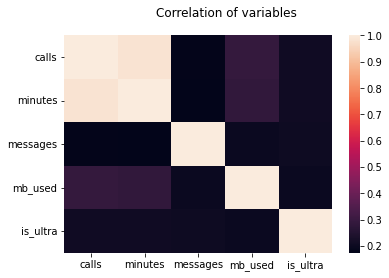

In [7]:
sns.heatmap(df.corr())
plt.suptitle("Correlation of variables")
plt.show()

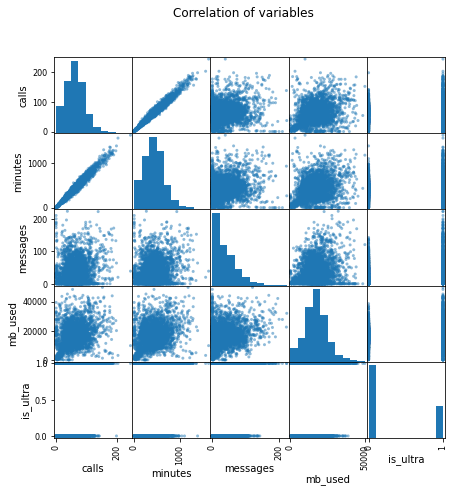

In [8]:
pd.plotting.scatter_matrix(df, figsize=(7, 7))
plt.suptitle("Correlation of variables")
plt.show()

In [9]:
df = df.drop('minutes', axis = 1)

## Divide the data into samples

Let's decide on what signs future models will learn and what will be the target indicator (target):

In [10]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

We need to split the original dataframe into **3 parts**:
* `train` - data set on which we will train the model (**3 parts**)
* `valid` - a data set on which the quality of the algorithm is checked during model training (**1 part**)
* `test` - data set, on which the quality of the trained model will be checked (**1 part**)

In [11]:
features_train_union, features_test, target_train_union, target_test = train_test_split(
    features, target, test_size = 0.2, random_state = 12345, stratify = target) 

We will use the test sample at the very end, when the models are trained and tested.

Next, we split tds into train and valid

In [12]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_union, target_train_union, test_size = 0.25, random_state = 12345, stratify = target_train_union) 

Let's check the distribution by shares:

In [13]:
print("{0:.0%}".format(len(features_train)/len(df)))
print("{0:.0%}".format(len(features_valid)/len(df)))
print("{0:.0%}".format(len(features_test)/len(df)))

60%
20%
20%


**Conclusion**
* determined the target feature and the features on which we will train the model
* split the original data into **train-valid-test** in the ratio **3-1-1**

In [14]:
print(f"Number of rows in target_train_union by class: {np.bincount(target_train_union)}")
print(f"Number of rows in target_train by class: {np.bincount(target_train)}")
print(f"Number of rows in target_valid by class: {np.bincount(target_valid)}")
print(f"Number of lines in target_test by class: {np.bincount(target_test)}")

Number of rows in target_train_union by class: [1783  788]
Number of rows in target_train by class: [1337  591]
Number of rows in target_valid by class: [446 197]
Number of lines in target_test by class: [446 197]


## Explore models

### Logistic regression

In [15]:
model_lr = LogisticRegression(random_state = 12345, solver = 'lbfgs')

In [16]:
%%time
model_lr.fit(features_train, target_train) 

CPU times: user 98 ms, sys: 15.5 ms, total: 113 ms
Wall time: 200 ms


LogisticRegression(random_state=12345)

In [17]:
print("{0:.000%}".format(model_lr.score(features_valid, target_valid)))

71%


### Decision tree

Here we add the selection of hyperparameters.

In [18]:
%%time
best_dt_model = None
best_dt_result = 0
best_dt_depth = 0

for i in range(1, 6):
    model_dt = DecisionTreeClassifier(random_state = 12345, max_depth = i)
    model_dt.fit(features_train, target_train) 
    predictions_valid_dt = model_dt.predict(features_valid) 
    result_dt = accuracy_score(target_valid, predictions_valid_dt)
    if result_dt > best_dt_result:
        best_dt_model = model_dt
        best_dt_result = result_dt
        best_dt_depth = i

print("Accuracy the best model on the validation set:", ("{0:.000%}".format(best_dt_result)), 
      "Tree depth:", best_dt_depth)

Accuracy the best model on the validation set: 80% Tree depth: 5
CPU times: user 29.8 ms, sys: 4.53 ms, total: 34.4 ms
Wall time: 37.1 ms


### Random Forest

Here we add the selection of hyperparameters.

In [19]:
%%time
best_rf_model = None
best_rf_result = 0
best_rf_est = 0
best_rf_depth = 0

for est in range(10, 51, 10):
    for depth in range (1, 11):
        model_rf = RandomForestClassifier(random_state = 12345, n_estimators = est, max_depth = depth)
        model_rf.fit(features_train,target_train) 
        predictions_valid_rf = model_rf.predict(features_valid) 
        result_rf = accuracy_score(target_valid, predictions_valid_rf)
        if result_rf > best_rf_result:
            best_rf_model = model_rf
            best_rf_result = result_rf
            best_rf_est = est
            best_rf_depth = depth
print("Accuracy the best model on the validation set:", ("{0:.000%}".format(best_rf_result)), 
      "Tree depth:", best_rf_depth, "N estimators:", best_rf_est)

Accuracy the best model on the validation set: 83% Tree depth: 7 N estimators: 10
CPU times: user 4.16 s, sys: 52.5 ms, total: 4.21 s
Wall time: 4.25 s


**Conclusion**
- trained 3 models in turn and compared their accuracy on the validation set
- hyperparameters were selected for the Random Forest and Decision Tree, which made it possible to achieve higher accuracy of the models
- Random Forest showed the best accuracy on the validation set, this is not very surprising, the algorithm also turned out to be the most resource-intensive.

## Check the model on the test set

In [20]:
## Random Forest
model_rf_union = RandomForestClassifier(random_state = 12345, n_estimators = best_rf_est, max_depth = best_rf_depth)
model_rf_union.fit(features_train_union, target_train_union) 

RandomForestClassifier(max_depth=7, n_estimators=10, random_state=12345)

In [21]:
### Decision tree
model_dt_union = DecisionTreeClassifier(random_state = 12345, max_depth = best_dt_depth)
model_dt_union.fit(features_train_union, target_train_union) 

DecisionTreeClassifier(max_depth=5, random_state=12345)

In [22]:
### Logistic regression
model_lr_union = LogisticRegression(random_state = 12345, solver = 'lbfgs')
model_lr_union.fit(features_train_union, target_train_union) 

LogisticRegression(random_state=12345)

Reached the final score.
We make a prediction on previously trained models:

In [23]:
%%time

final_lr = model_lr.predict(features_test)
final_dt = best_dt_model.predict(features_test)
final_rf = best_rf_model.predict(features_test)

CPU times: user 11.1 ms, sys: 2.55 ms, total: 13.6 ms
Wall time: 11.8 ms


Assessing the quality:

In [24]:
result_final_lr = accuracy_score(final_lr, target_test)
result_final_dt = accuracy_score(final_dt, target_test)
result_final_rf = accuracy_score(final_rf, target_test)

In [25]:
print("Accuracy Логистическая регрессия:", ("{0:.000%}".format(result_final_lr)))
print("Accuracy Решающее дерево:", ("{0:.000%}".format(result_final_dt)))
print("Accuracy Случайный лес:", ("{0:.000%}".format(result_final_rf)))

Accuracy Логистическая регрессия: 70%
Accuracy Решающее дерево: 81%
Accuracy Случайный лес: 80%


In [26]:
%%time

final_lr_union = model_lr_union.predict(features_test)
final_dt_union  = model_dt_union.predict(features_test)
final_rf_union  = model_rf_union.predict(features_test)

CPU times: user 11 ms, sys: 2.62 ms, total: 13.6 ms
Wall time: 13.2 ms


In [27]:
result_final_lr_union  = accuracy_score(final_lr_union , target_test)
result_final_dt_union  = accuracy_score(final_dt_union , target_test)
result_final_rf_union  = accuracy_score(final_rf_union , target_test)

In [28]:
print("Accuracy Logistic regression:", ("{0:.000%}".format(result_final_lr_union)))
print("Accuracy Decision tree:", ("{0:.000%}".format(result_final_dt_union)))
print("Accuracy Random Forest:", ("{0:.000%}".format(result_final_rf_union)))

Accuracy Logistic regression: 74%
Accuracy Decision tree: 79%
Accuracy Random Forest: 81%


**Conclusion**
- all 3 models showed a fairly high prediction accuracy on the test sample (more than 75% for all)
- leader in the share of correct answers - random forest - 81%

*Observation*
The decision tree and regression on the test showed slightly higher accuracy than on the validation set.

## (bonus) Check models for adequacy

In [29]:
from sklearn.dummy import DummyClassifier

We looked at the distribution of the target in the initial data:

In [30]:
df['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Strategy - always predicts the most frequently occurring label in the training set.

In our case, everything will be filled with 0 values

In [31]:
dummy_clf = DummyClassifier(strategy = 'most_frequent')

Trained dummy model:

In [32]:
dummy_clf.fit(features, target)

DummyClassifier(strategy='most_frequent')

In [33]:
dummy_clf_mdl = dummy_clf.predict(features)

In [34]:
print('Accuracy dummy-model',"{0:.000%}".format(accuracy_score(dummy_clf_mdl, target)))

Accuracy dummy-model 69%


Accuracy our models

In [35]:
print("Accuracy logistic regression:", ("{0:.000%}".format(result_final_lr_union)))
print("Accuracy decision tree:", ("{0:.000%}".format(result_final_dt_union)))
print("Accuracy random forest:", ("{0:.000%}".format(result_final_rf_union)))

Accuracy logistic regression: 74%
Accuracy decision tree: 79%
Accuracy random forest: 81%


**Accuracy metric for any of our models is higher than just populating everything with the most frequent target-column value**

**General conclusion**
- in the project on labeled data, we tried to predict the sign of the current tariff for the client based on his activity and consumption of services
- the original dataset was split into `train` - `valid` - `test`, the target feature was defined
- `logistic regression` - `decision tree` - `random forest` were trained sequentially (for the last two models, hyperparameters were selected, which made it possible to increase their accuracy)
- the maximum share of correct answers on the test sample was shown by the Random Forest model - 80% (it also showed the highest resource intensity - the model studied on the cluster for the longest time)